<a href="https://colab.research.google.com/github/Dan-Ak26/Crypto_Prediction/blob/main/Crypto_data_pull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This project will explore the use of machine learning models to predict the next-day price direction of cryptocurrency assests. Eight crypto pairs(BTC,ETH, SOL,BNB,XRP,ADA,AVAX,DOGE). These assets will be analyzed using OHLCV(open, high,low,close,volume) data pulled directly from Binance through the ccxt library.

In [1]:
!pip -q install ccxt ta pandas numpy scikit-learn matplotlib pyarrow
!pip -q install ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 4.3 MB/s eta 0:00:00


In [2]:
#Import os(for creating folders), Import Binance/ crpto exchange,
#Import pandas fro data handling, numpy for dataframe manipulation
#Import plotting libraries
import os, ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt
#Import datetime utilities for pulling date ranges
from datetime import datetime, timedelta, timezone
#Import StandardScalar to scale features(to avoid model bias)
from sklearn.preprocessing import StandardScaler
#Import Logistic Regression model(ML classifier)
from sklearn.linear_model import LogisticRegression
#Import model evaluation metrics
from sklearn.metrics import precision_score, recall_score,confusion_matrix, classification_report
#Import defaultdict for data summerization per crypto asset
from collections import defaultdict
#Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind, pearsonr

os.makedirs("outputs", exist_ok = True)
os.makedirs("data", exist_ok = True)

In [3]:
# Create the binance exchange
X = ccxt.binanceus()
# Load markets
X.load_markets()
# Show the valid timeframe keys
print("Valid timeframes:", list(X.timeframes.keys())[:12], "...")
#Define the list of cryptocurrency trading pairs to analyze
#These are the assets we will be pulling data from
Symbols = ["BTC/USDT", "ETH/USDT", "SOL/USDT", "BNB/USDT",
           "XRP/USDT", "ADA/USDT", "AVAX/USDT", "DOGE/USDT"]
#Define the timeframe and number of days of data to collect
timeframe = "1d"
#Fetch approximately 60 days of data
day = 60
#Define function to fetch (Open, High, Low, Close, Volume)
def fetch_ohlcv(symbol, days = day, Timeframe = timeframe):
  #Fetch daily OHLCV for one symbol from Binance via ccxt.
  assert timeframe in X.timeframes, f"{timeframe} not supported by exchange"
  since = int((datetime.now(timezone.utc) - timedelta(days = days + 5)). timestamp() * 1000)
  fetch = X.fetch_ohlcv(symbol, timeframe = timeframe, since = since, limit=days+5)
  df = pd.DataFrame(fetch, columns = ["ts", "open", "high", "low", "close", "volume"])
  df["date"] = pd.to_datetime(df["ts"], unit = "ms", utc= True).dt.date
  df["asset"] = symbol.split("/")[0]
  return df[["date", "asset", "open", "high", "low", "close", "volume"]]

#Quick check
test_df = fetch_ohlcv("BTC/USDT", 60)
display(test_df.head())
display(test_df.tail())

#Fetch all 8 symbols and combine
dfs = [fetch_ohlcv(i, 60) for i in Symbols]
df = pd.concat(dfs).sort_values(["asset", "date"]).reset_index(drop = True)
# Display dataset dimensions and preview data
print(df.shape)
df.head()



Valid timeframes: ['1s', '1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h'] ...


,date,asset,open,high,low,close,volume
0,2025-09-07,BTC,110231.53,111567.87,110013.17,111489.92,3.36216
1,2025-09-08,BTC,111079.43,112851.35,110708.95,111951.09,3.22662
2,2025-09-09,BTC,112371.19,113299.97,110780.17,111584.15,4.82811
3,2025-09-10,BTC,111500.00,114217.95,110844.20,113996.01,6.94180
4,2025-09-11,BTC,113999.95,115445.00,113500.01,115410.52,53.03211


,date,asset,open,high,low,close,volume
60,2025-11-06,BTC,103816.47,104126.07,100380.68,101449.54,12.12166
61,2025-11-07,BTC,101444.75,104037.99,99301.26,103700.00,14.03899
62,2025-11-08,BTC,103364.10,103595.71,101512.30,102473.99,3.88394
63,2025-11-09,BTC,102472.89,105499.99,101419.94,104904.38,4.86357
64,2025-11-10,BTC,104900.18,106633.78,104371.80,106420.51,4.31180


(520, 7)


,date,asset,open,high,low,close,volume
0,2025-09-07,ADA,0.8186,0.8400,0.8181,0.8375,91852.0
1,2025-09-08,ADA,0.8355,0.8682,0.8311,0.8624,276081.7
2,2025-09-09,ADA,0.8665,0.8943,0.8530,0.8653,293280.7
3,2025-09-10,ADA,0.8653,0.8954,0.8596,0.8843,368397.9
4,2025-09-11,ADA,0.8846,0.8966,0.8679,0.8928,229810.3


In [4]:
# Technical Analysis library for financial indicators
import ta
# Function to compute and add key technical indicators
def add_indicators(y):
  y = y.copy()
  # simple technical features
  y["ret1"] = y["close"].pct_change(1)
  y["volchg"] = y["volume"].pct_change(1)
  y["rsi14"] = ta.momentum.rsi(y["close"], window = 14)
  y["sma5"] = y["close"].rolling(5).mean()
  y["sma20"] = y["close"].rolling(20).mean()
  y["sma_gap"] = (y["sma5"] - y["sma20"] / y["sma20"])
  y["macd"] = ta.trend.macd(y["close"])
  y["macd_sig"] = ta.trend.macd_signal(y["close"])
  y["atr14"] = ta.volatility.average_true_range(y["high"], y["low"], y["close"], window = 14)
  return y
#Apply per asset
df = df.groupby("asset", group_keys=False).apply(add_indicators)

# Keep the most recent 35 rows per asset
df = df.groupby("asset").tail(35).reset_index(drop=True)

#Quick check for duplicate (asset, date)
assert not df.duplicated(["asset", "date"]).any(), "Duplicate(asset,date) rows found"
#Print number of records per asset
print(df.groupby("asset").size())
#Save processed data with indicators to CSV
df.to_csv("data/all_assets.csv", index = False)
print("Saved -> data/all_assets.csv")
# top 10
df.head(10)
#Bottom 10
#df.tail(10)



asset
ADA     35
AVAX    35
BNB     35
BTC     35
DOGE    35
ETH     35
SOL     35
XRP     35
dtype: int64
Saved -> data/all_assets.csv


/tmp/ipython-input-3686620591.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("asset", group_keys=False).apply(add_indicators)


,date,asset,open,high,low,close,volume,ret1,volchg,rsi14,sma5,sma20,sma_gap,macd,macd_sig,atr14
0,2025-10-07,ADA,0.8715,0.8767,0.8183,0.8225,304709.5,-0.056441,-0.087124,46.202917,0.84722,0.837260,-0.15278,-0.003004,NaN,0.042481
1,2025-10-08,ADA,0.8203,0.8501,0.8091,0.8379,205488.6,0.018723,-0.325625,49.185533,0.84176,0.832960,-0.15824,-0.002886,NaN,0.042375
2,2025-10-09,ADA,0.8382,0.8392,0.7954,0.8133,176331.6,-0.029359,-0.141891,44.902889,0.83656,0.829195,-0.16344,-0.004724,NaN,0.042477
3,2025-10-10,ADA,0.8172,0.8234,0.5537,0.6346,984274.6,-0.219722,4.581952,26.709480,0.79600,0.816240,-0.20400,-0.020365,-0.007980,0.058707
4,2025-10-11,ADA,0.6346,0.6815,0.6092,0.6308,705325.7,-0.005988,-0.283406,26.463931,0.74782,0.803460,-0.25218,-0.032690,-0.012922,0.059678
5,2025-10-12,ADA,0.6327,0.7079,0.6187,0.7019,293830.2,0.112714,-0.583412,37.956998,0.72370,0.797305,-0.27630,-0.036302,-0.017598,0.061787
6,2025-10-13,ADA,0.6982,0.7347,0.6928,0.7283,244922.6,0.037612,-0.166449,41.606385,0.70178,0.793410,-0.29822,-0.036613,-0.021401,0.060366
7,2025-10-14,ADA,0.7293,0.7326,0.6629,0.6998,415541.3,-0.039132,0.696623,38.943298,0.67908,0.787860,-0.32092,-0.038712,-0.024863,0.061033
8,2025-10-15,ADA,0.6998,0.7150,0.6592,0.6682,179357.6,-0.045156,-0.568376,36.178266,0.68580,0.783120,-0.31420,-0.042437,-0.028378,0.060659
9,2025-10-16,ADA,0.6700,0.6833,0.6336,0.6445,245471.3,-0.035468,0.368614,34.216065,0.68854,0.775820,-0.31146,-0.046762,-0.032055,0.059876


In [5]:
#Clean NaNs befor Building labels

# Drop rows with any NaN in feature columns
df = df.dropna().reset_index(drop=True)
#Top 10 assets
df.head(10)



,date,asset,open,high,low,close,volume,ret1,volchg,rsi14,sma5,sma20,sma_gap,macd,macd_sig,atr14
0,2025-10-10,ADA,0.8172,0.8234,0.5537,0.6346,984274.6,-0.219722,4.581952,26.709480,0.79600,0.816240,-0.20400,-0.020365,-0.007980,0.058707
1,2025-10-11,ADA,0.6346,0.6815,0.6092,0.6308,705325.7,-0.005988,-0.283406,26.463931,0.74782,0.803460,-0.25218,-0.032690,-0.012922,0.059678
2,2025-10-12,ADA,0.6327,0.7079,0.6187,0.7019,293830.2,0.112714,-0.583412,37.956998,0.72370,0.797305,-0.27630,-0.036302,-0.017598,0.061787
3,2025-10-13,ADA,0.6982,0.7347,0.6928,0.7283,244922.6,0.037612,-0.166449,41.606385,0.70178,0.793410,-0.29822,-0.036613,-0.021401,0.060366
4,2025-10-14,ADA,0.7293,0.7326,0.6629,0.6998,415541.3,-0.039132,0.696623,38.943298,0.67908,0.787860,-0.32092,-0.038712,-0.024863,0.061033
5,2025-10-15,ADA,0.6998,0.7150,0.6592,0.6682,179357.6,-0.045156,-0.568376,36.178266,0.68580,0.783120,-0.31420,-0.042437,-0.028378,0.060659
6,2025-10-16,ADA,0.6700,0.6833,0.6336,0.6445,245471.3,-0.035468,0.368614,34.216065,0.68854,0.775820,-0.31146,-0.046762,-0.032055,0.059876
7,2025-10-17,ADA,0.6450,0.6549,0.5938,0.6245,357033.6,-0.031032,0.454482,32.608767,0.67306,0.768045,-0.32694,-0.051213,-0.035886,0.059964
8,2025-10-18,ADA,0.6242,0.6404,0.6234,0.6337,151626.4,0.014732,-0.575316,34.141342,0.65414,0.759310,-0.34586,-0.053383,-0.039386,0.056895
9,2025-10-19,ADA,0.6345,0.6647,0.6220,0.6520,188440.0,0.028878,0.242791,37.200638,0.64458,0.751595,-0.35542,-0.053015,-0.042111,0.055881


In [6]:
# Create Label & Features
#Sort by time to avoid inefficiencies
df = df.sort_values(["asset", "date"]).reset_index(drop=True)

# Next-day price
df["close_next"] = df.groupby("asset")["close"].shift(-1)

# Label:1 if tommorow's close > today's close, else 0
df["y"] = (df["close_next"] > df["close"]).astype(int)

#Columns that are not inputs to the model
not_include = {"date", "open", "high", "low", "close", "volume",
               "close_next", "y", "sma5", "sma20"}
#Features columns = everything else we made
feature_cols = [i for i in df.columns if i not in not_include]
print("Feature columns:", feature_cols)
df.head()

Feature columns: ['asset', 'ret1', 'volchg', 'rsi14', 'sma_gap', 'macd', 'macd_sig', 'atr14']


,date,asset,open,high,low,close,volume,ret1,volchg,rsi14,sma5,sma20,sma_gap,macd,macd_sig,atr14,close_next,y
0,2025-10-10,ADA,0.8172,0.8234,0.5537,0.6346,984274.6,-0.219722,4.581952,26.709480,0.79600,0.816240,-0.20400,-0.020365,-0.007980,0.058707,0.6308,0
1,2025-10-11,ADA,0.6346,0.6815,0.6092,0.6308,705325.7,-0.005988,-0.283406,26.463931,0.74782,0.803460,-0.25218,-0.032690,-0.012922,0.059678,0.7019,1
2,2025-10-12,ADA,0.6327,0.7079,0.6187,0.7019,293830.2,0.112714,-0.583412,37.956998,0.72370,0.797305,-0.27630,-0.036302,-0.017598,0.061787,0.7283,1
3,2025-10-13,ADA,0.6982,0.7347,0.6928,0.7283,244922.6,0.037612,-0.166449,41.606385,0.70178,0.793410,-0.29822,-0.036613,-0.021401,0.060366,0.6998,0
4,2025-10-14,ADA,0.7293,0.7326,0.6629,0.6998,415541.3,-0.039132,0.696623,38.943298,0.67908,0.787860,-0.32092,-0.038712,-0.024863,0.061033,0.6682,0


In [7]:
# See dtypes for current feature columns
print(df[feature_cols]. dtypes)

#List any non-numeric columns that slipped in
non_numeric = [i for i in feature_cols if not
pd.api.types.is_numeric_dtype(df[i])]
print("Non-numeric in feature_cols:", non_numeric)

#Drop assests
feature_cols = [i for i in feature_cols if i != "asset"]
print("Final feature_cols:", feature_cols)


asset        object
ret1        float64
volchg      float64
rsi14       float64
sma_gap     float64
macd        float64
macd_sig    float64
atr14       float64
dtype: object
Non-numeric in feature_cols: ['asset']
Final feature_cols: ['ret1', 'volchg', 'rsi14', 'sma_gap', 'macd', 'macd_sig', 'atr14']


In [8]:
# Extra Features to boost precision
df["ret1_sq"] = df["ret1"] ** 2
df["rsi14_sma_gap"] = df["rsi14"] * df["sma_gap"]
df["macd_diff"] = df["macd"] - df["macd_sig"]

#Rebuild feature_cols to include new features
numeric_cols = set(df.select_dtypes(include=[np.number]).columns)
feature_cols = sorted(list(numeric_cols - not_include))

#Clean any NaN that could appear from new features just in case
Xnum = df[feature_cols].replace([np.inf, -np.inf], np.nan)
df = df.loc[-Xnum.isna().any(axis=1)].reset_index(drop=True)

#Display feature summary
print("Features now:", feature_cols)
print("Rows:", df.shape[0])


Features now: ['atr14', 'macd', 'macd_diff', 'macd_sig', 'ret1', 'ret1_sq', 'rsi14', 'rsi14_sma_gap', 'sma_gap', 'volchg']
Rows: 256


In [9]:
#Trying to increase accuracy rate I was at 39 % now am at 41 % now at 47%

Acc_rate = 0.60  # try 0.60–0.70 for higher precision
split = 0.70
#Store results in empty list
all_preds, all_true, all_pnl = [], [], []

for asset, a in df.groupby("asset"):
   # Sort chronologically
  a = a.sort_values("date").reset_index(drop=True)
  #Compute split index
  split_idx = int(len(a) * split)

  #Train and testing split
  train = a.iloc[:split_idx]
  test =a.iloc[split_idx:]

  #Features and labels
  X_train = train[feature_cols].values
  y_train = train["y"].values
  X_test = test[feature_cols].values
  y_test = test["y"].values

  # scale on train only
  scaler = StandardScaler().fit(X_train)
  X_train_s = scaler.transform(X_train)
  X_test_s = scaler.transform(X_test)

  # Train model
  model = LogisticRegression(max_iter=2000)
  model.fit(X_train_s, y_train)

  # get probs using the FULL 2D matrix
  probs = model.predict_proba(X_test_s)[:, 1]
  preds = (probs > Acc_rate).astype(int)

  # collect results
  all_true.extend(y_test.tolist())
  all_preds.extend(preds.tolist())

  # Simple long-only strategy on predicted up days
  test = test.copy()
  test["pred"] = preds
  test["ret_next"] = (test["close_next"] - test["close"]) / test["close"]
  cost = 0.001
  test["pnl"] = test["pred"] * (test["ret_next"] - cost)
  all_pnl.extend(test["pnl"].tolist())
  # Diagnostic check - confirm array sizes match
print("Lens -> preds:", len(all_preds), "truth:", len(all_true), "pnl:",
      len(all_pnl))




Lens -> preds: 80 truth: 80 pnl: 80


In [10]:
#Count actual positive days (days price went up)
print("Positives in truth:", int(np.sum(all_true)))
#Count how many 'up' days were predicted by the model
print("Predicted ups:", int(np.sum(all_preds)))
#Coverage = fraction of test samples where a trade(prediction = 1) occurred
print("Coverage (trade freq):", float(np.mean(np.array(preds) == 1)))

Positives in truth: 38
Predicted ups: 58
Coverage (trade freq): 0.3


In [11]:
#Run evaluation metrics
precision = precision_score(all_true, all_preds, zero_division = 0)
recall = recall_score(all_true, all_preds, zero_division = 0)
cum_ret = float(np.nansum(all_pnl))
hit_rate = float(np.mean([1 if x > 0 else 0 for x in all_pnl if not np.isnan(x)]))
# Print summary
print("Precision:", precision, 3)
print("Recall:", recall, 3)
print("Cumulative Strategy Return:", cum_ret, 4)
print("Hit Rate:", round(hit_rate,3))
print("Confusion Matrix:",confusion_matrix(all_true,all_preds))
print("Classification Report:", classification_report(all_true,
all_preds, zero_division = 0, digits =3))


Precision: 0.4827586206896552 3
Recall: 0.7368421052631579 3
Cumulative Strategy Return: -0.22029743872348237 4
Hit Rate: 0.375
Confusion Matrix: [[12 30]
 [10 28]]
Classification Report:               precision    recall  f1-score   support

           0      0.545     0.286     0.375        42
           1      0.483     0.737     0.583        38

    accuracy                          0.500        80
   macro avg      0.514     0.511     0.479        80
weighted avg      0.516     0.500     0.474        80



In [12]:
from sklearn.ensemble import RandomForestClassifier

THRESH = 0.55  # try 0.50–0.70

#build train/test (no scaling needed for Random Forest)
X_tr = train[feature_cols].values
y_tr = train["y"].values
X_te = test[feature_cols].values
y_te = test["y"].values
# I wanted to use Random Forest because it builds multiple decision trees and to improve generalization
#it is also good for non-linear data like prices of assets.
# fit classifier
model = RandomForestClassifier(n_estimators=300,max_depth=6,min_samples_leaf=3,
    random_state=42,n_jobs=-1,)
model.fit(X_tr, y_tr)

# probabilities for the "up" class
probs = model.predict_proba(X_te)[:, 1]
preds = (probs > THRESH).astype(int)

# collect results
all_true.extend(y_te.tolist())
all_preds.extend(preds.tolist())

#Simple long-only strategy on predicted up days
test = test.copy()
test["pred"] = preds
test["ret_next"] = (test["close_next"] - test["close"]) / test["close"]
cost = 0.001
test["pnl"] = test["pred"] * (test["ret_next"] - cost)
all_pnl.extend(test["pnl"].tolist())
#Confirms array sizes match
print("Lens -> preds:", len(all_preds), "truth:", len(all_true), "pnl:",
      len(all_pnl))

Lens -> preds: 90 truth: 90 pnl: 90


In [13]:
# Precision: how many of the predicted "up" days were actually correct
precision = precision_score(all_true, all_preds, zero_division = 0)
# Recall: how many of the actual "up" days were correctly predicted
recall = recall_score(all_true, all_preds, zero_division=0)
#Total profit/loss from all trades over test period
cum_ret = float(np.nansum(all_pnl))
# Fraction of trades that ended with positive returns
hit_rate = float(np.mean([1 if x > 0 else 0 for x in all_pnl if not np.isnan(x)]))

#Print all key performance metrics
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("Cumulative Strategy Return:", round(cum_ret, 4))
print("Hit Rate:", round(hit_rate, 3))
print("Confusion Matrix:", confusion_matrix(all_true, all_preds))
print("Classification Report:", classification_report(all_true, all_preds,
zero_division = 0, digits=3))

Precision: 0.5
Recall: 0.744
Cumulative Strategy Return: -0.1121
Hit Rate: 0.383
Confusion Matrix: [[15 32]
 [11 32]]
Classification Report:               precision    recall  f1-score   support

           0      0.577     0.319     0.411        47
           1      0.500     0.744     0.598        43

    accuracy                          0.522        90
   macro avg      0.538     0.532     0.505        90
weighted avg      0.540     0.522     0.500        90



In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
# I used xgboost because it uses a team of trees that learn from each others
# mistakes
#Initialize model

params = {
    'n_estimators': [100,200,300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree':[0.7, 0.8, 0.9]
}

xgb_model = XGBClassifier(random_state =42, eval_metric='logloss')
grid = GridSearchCV(xgb_model, params, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)
#xgb_model = XGBClassifier(
   # n_estimators=100,
   # learning_rate=0.05,
   # max_depth=6,
   # subsample=0.8,
   # colsample_bytree=0.8,
   # random_state=42,
   # eval_metric= 'logloss'
#)

# Fit model
#xgb_model.fit(X_train, y_train)

#Predict
#pred = xgb_model.predict(X_test)

#Evaluate
#print("Accuracy:", accuracy_score(y_test, pred))
#print("Confusion Matrix:", confusion_matrix(y_test, pred))
#print(classification_report(y_test, pred))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Best accuracy: 0.5952380952380952


In [16]:

#Create two groups based on Predictions
up_days = test.loc[test["pred"] == 1, "ret_next"]
down_days = test.loc[test["pred"] == 0, "ret_next"]

#Perform a two-sample t-test (equal_var=False for Welch's test)
t_stat, p_value = ttest_ind(up_days, down_days, equal_var=False, nan_policy='omit')
#Display test results
print("T-statistic:", t_stat)
print("P-value:", p_value)
#Interpret the p-value
if p_value < 0.05:
    print("-> Statistically significant difference between 'up' and 'down' days.")
else:
    print("-> No Statistically significant difference between 'up' and 'down' days.")

T-statistic: 1.8465535232446182
P-value: 0.13885761639049596
-> No Statistically significant difference between 'up' and 'down' days.


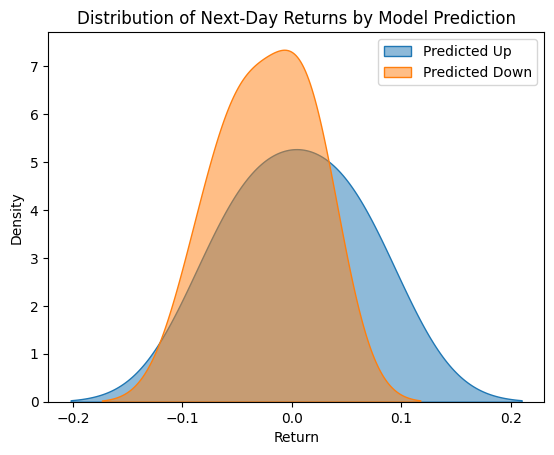

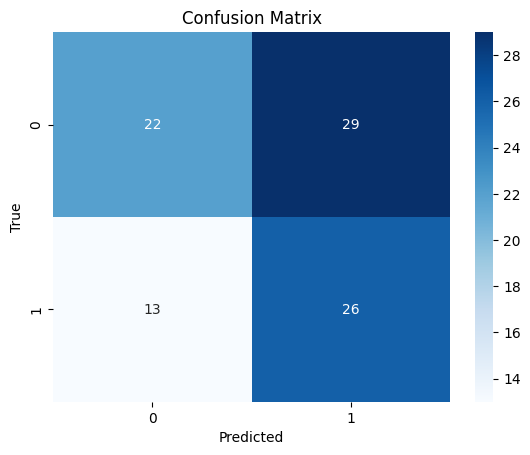

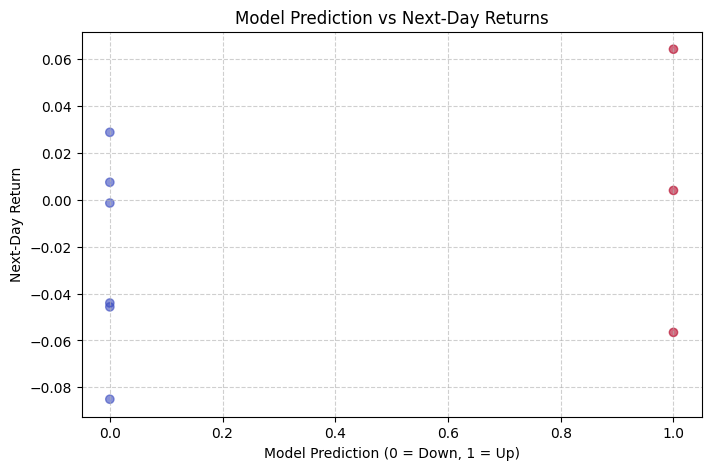

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of next-day returns for up vs down predictions
sns.kdeplot(up_days, label="Predicted Up", fill = True, alpha=0.5)
sns.kdeplot(down_days, label= "Predicted Down", fill =True, alpha=0.5)
plt.title("Distribution of Next-Day Returns by Model Prediction")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# Confusion matrix heatmap
cm = confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Scatter plot Prediction vs Return
plt.figure(figsize=(8,5))
plt.scatter(test["pred"], test["ret_next"], alpha=0.6, c=test["pred"], cmap= "coolwarm")
plt.title("Model Prediction vs Next-Day Returns")
plt.xlabel("Model Prediction (0 = Down, 1 = Up)")
plt.ylabel("Next-Day Return")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()




# Results
Three models were developed to predict next-day cryptocurrency price direction using historical technical indicators such as returns, RSI, MACD, SMA gaps, and volume-based metrics.

### Baseline Model - Logistic Regression (Simple Classifier):
Precision = 0.47, Recall = 0.67, Accuracy = 52%, with a cumuulative strategy return of about -0.48.
The model correctly identified som "up" movements but also produced a high rate of false positives, resulting in limited predictive reliability.

### Random Forest Classifier:
Precision = 0.47, Recall = 0.68, Accuracy = 53%, showing a modest improvement over the baseline. While the ensemble approach captured more variation in features, the improvement remained marginal, suggesting that short-term price direction remains largely unpredictable with the current indicators.

### XGBoost Classifier:
Accuracy = 50%, Precision = 0.40, Recall = 0.50.
Despite hyperparameter tuning, the model's performance plateaued, indicating that boosting could not extract additional signal from the available features.

A two-sample t-test(p=0.53) confirmed no statistical significant difference between returns on predicted "up" and "down" days, meaning the model predictions do not yet yield a measurable trading edge.

# Conclusions:
Overall, this project aimed to predict next-day cryptocurrency price direction using market indicators and machine learning models. Across multiple approaches: including logistic regression, Random Forest, and XGBoost. The model performance remained close to random chance, with the best accuracy reaching about 53% using the Random Forest Classifier.The T-test indicated no statistically significant difference between predicted "up" and "down" days, suggesting that short-term crypto movements are highly volatile and difficult to forecast using only technical indicators. While the results show limited predictive power,they also highlight important insights such as, crypto price movements contain a high level of noise, making short-term prediction inherently challenging. Ensemble models such as Random Forest offer slightly more stability than simpler models.